In [10]:
import time
import numpy as np
import torch

from sbi import utils as utils
from sbi import analysis as analysis
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import bernoulli_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2
    
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
matplotlib.rcParams.update({
    'font.family' : 'times',
    'font.size' : 14.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (2.5, 2.5),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : True
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': '#00416A', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}


plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

In [6]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [7]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Bernoulli SIR

In [8]:
bern_sir = bernoulli_sir.BernSIR()

## data generation

In [ ]:
# DON'T NEED TO RUN
N = 50000

bern_sir_theta_npe_large = bern_sir.sample_theta([N]).reshape(-1, bern_sir.theta_dim)
bern_sir_x_npe_large = torch.empty([N, bern_sir.x_dim])
for i in range(N):
    bern_sir_x_npe_large[i, :] = bern_sir(bern_sir_theta_npe_large[i])

torch.save(bern_sir_x_npe_large, "data/bern_sir_x_npe_large.pt")
torch.save(bern_sir_theta_npe_large, "data/bern_sir_theta_npe_large.pt")

In [11]:
# Use triton to generate data
N = 50000

bern_sir_theta_npe_large = bern_sir.sample_theta([N]).reshape(-1, bern_sir.theta_dim)
bern_sir_x_npe_large = torch.empty([N, bern_sir.x_dim])
for i in range(100):
    bern_sir_x_npe_large[500*i: 500*(i+1), :] = torch.load(f"data/bern_sir_large/bern_sir_x_npe_large_{i+1}.pt")
    bern_sir_theta_npe_large[500*i: 500*(i+1), :] = torch.load(f"data/bern_sir_large/bern_sir_theta_npe_large_{i+1}.pt")

torch.save(bern_sir_x_npe_large, "data/bern_sir_x_npe_large.pt")
torch.save(bern_sir_theta_npe_large, "data/bern_sir_theta_npe_large.pt")

In [91]:
# DON'T NEED TO RUN
bern_sir_obs_theta = torch.tensor([0.5, 0.5, 0.5])
bern_sir_obs_x = bern_sir(bern_sir_obs_theta)
bern_sir_obs_x

In [56]:
# DON'T NEED TO RUN
torch.save(bern_sir_obs_x, "data/bern_sir_obs_x.pt")
torch.save(bern_sir_obs_theta, "data/bern_sir_obs_theta.pt")

## Load data

In [65]:
bern_sir_x_npe_large = torch.load("data/bern_sir_x_npe_large.pt")
bern_sir_theta_npe_large = torch.load("data/bern_sir_theta_npe_large.pt")

bern_sir_obs_x = torch.load("data/bern_sir_obs_x.pt")
bern_sir_obs_theta = torch.load("data/bern_sir_obs_theta.pt")

## Fit GP

In [66]:
# for gp
n_train_pair = 500
X = bern_sir_theta_npe_large[:n_train_pair]
n_rep = 10

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(bern_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = (et - st) / n_rep

In [78]:
# save GP training samples
torch.save(X, "data/bern_sir_gp_x.pt")
torch.save(times_train, "data/bern_sir_gp_y.pt")

In [79]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')


torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict()
}, 'data/bern_sir_gp.pth')


In [54]:
model.eval()
likelihood.eval()

N = 100

beta = torch.linspace(0.1, 1, N)
beta_fixed = 0.5


gamma_fixed = 0.5
gamma = torch.linspace(0.1, 1, N)

p = torch.linspace(0.1, 1, N)
p_fixed = 0.5

beta_combined = beta_fixed * torch.ones_like(beta)
gamma_combined = gamma_fixed * torch.ones_like(gamma)
p_combined = p_fixed * torch.ones_like(p)

combination_beta = torch.stack((beta, gamma_combined, p_combined), dim=1)
combination_gamma = torch.stack((beta_combined, gamma, p_combined), dim=1)
combination_p = torch.stack((beta_combined, gamma_combined, p), dim=1)

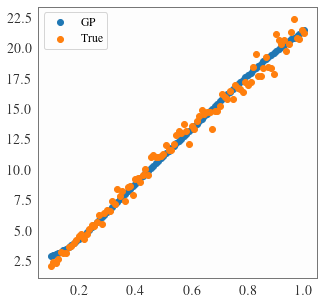

In [72]:
times_vs_beta = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_beta[i])
    et = time.time()
    times_vs_beta[i] = (et - st)
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_beta)).mean

plt.figure(figsize=[5,5])
plt.scatter(beta, observed_pred*20, label="GP")
plt.scatter(beta, times_vs_beta, label="True")
plt.legend()
plt.show()

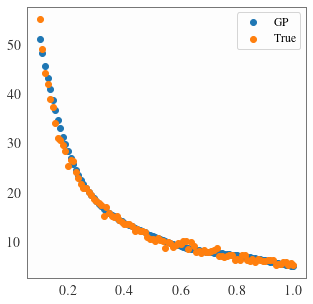

In [76]:
times_vs_gamma = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_gamma[i])
    et = time.time()
    times_vs_gamma[i] = (et - st)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_gamma)).mean

plt.figure(figsize=[5,5])
plt.scatter(gamma, observed_pred* 20, label="GP")
plt.scatter(gamma, times_vs_gamma, label="True")
plt.legend()
plt.show()

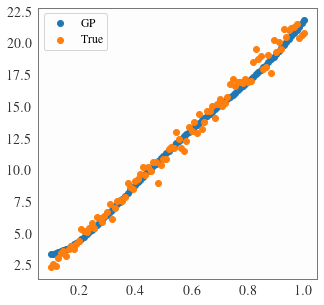

In [75]:
times_vs_p = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_p[i])
    et = time.time()
    times_vs_p[i] = (et - st)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_p)).mean

plt.figure(figsize=[5,5])
plt.scatter(p, observed_pred*20, label="GP")
plt.scatter(p, times_vs_p, label="True")
plt.legend()
plt.show()

In [109]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(torch.tensor([1.0, 0.1, 1.0]).reshape(1, -1))).mean
    
print(observed_pred)

In [45]:
state_dicts = torch.load('data/bern_sir_gp.pth')

X = torch.load("data/bern_sir_gp_x.pt")
times_train = torch.load("data/bern_sir_gp_y.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

prior_start = torch.tensor([0.1, 1.0, 0.1]).reshape(-1, 3)
k = 2

# num_sim = 5000
# theta_tilde = torch.zeros([num_sim, 3])
# count = 0
# while count < num_sim:
#     theta = bern_sir.sample_theta([1]).reshape(-1, 3)
#     if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
#         theta_tilde[count] = theta.reshape(-1)
#         count += 1

In [53]:
prior_start = torch.tensor([0.1, 1.0, 0.1]).reshape(-1, 3)
n_rep = 20

st = time.time()
for _ in range(n_rep):
    result = bern_sir(prior_start.reshape(-1))
et = time.time()
times_start = (et - st) / n_rep
print(times_start)

0.0017529606819152832


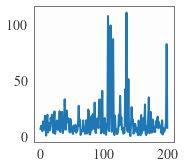

In [48]:
plt.plot(times_train)

In [73]:
prior_end = torch.tensor([1., 0.1, 1.0]).reshape(-1, 3)

g_min = likelihood(model(prior_start)).mean / 10
g_max = likelihood(model(prior_end)).mean / 10

print(g_min ** 0.5)
print(g_min ** 1)
print(g_min ** 2)

print(g_max ** 0.5)
print(g_max ** 1)
print(g_max ** 2)

tensor([0.1197], grad_fn=<PowBackward0>)
tensor([0.0143], grad_fn=<PowBackward0>)
tensor([0.0002], grad_fn=<PowBackward0>)
tensor([0.9190], grad_fn=<PowBackward0>)
tensor([0.8447], grad_fn=<PowBackward0>)
tensor([0.7134], grad_fn=<PowBackward0>)


In [36]:
w = likelihood(model(theta_tilde)).mean.detach() ** k

In [37]:
theta_prior = bern_sir.sample_theta([5000]).reshape(-1, 3)

In [40]:
plt.hist(theta_prior.detach().numpy()[:, 0], bins=10)
plt.hist(theta_tilde.detach().numpy()[:, 0], bins=10)
plt.show()

## CEG ESS

In [22]:
num_sim = 10000
num_repeats = 2
k = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]) # Exponent of the penaly function g(z) = z^k

prior_start = torch.tensor([0.1, 1.0, 0.1]).reshape(-1, 3)

ess_cost_aware = np.zeros([k.size, num_repeats])
ceg = np.zeros([k.size, num_repeats])

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:
            theta = bern_sir.sample_theta([num_sim])
            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros([num_sim, 3])
            count = 0
            while count < num_sim:
                param_value = bern_sir.sample_theta([1]).reshape(-1, 3)
                if calc_acc_prob(model, likelihood, param_value, prior_start, k[ind]) > torch.rand(1):
                    theta_tilde[count] = param_value.reshape(-1)
                    count += 1

            w_u = likelihood(model(theta_tilde)).mean.detach() ** k[ind]   #self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(likelihood(model(theta)).mean.detach()) / torch.mean(likelihood(model(theta_tilde)).mean.detach())
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim
    print(ind)

In [23]:
ess_cost_aware * ceg

## Train

In [41]:
# DON'T NEED TO RUN
bern_sir_inference_npe_large = SNPE_C()
bern_sir_nn_npe_large = bern_sir_inference_npe_large.append_simulations(
    bern_sir_theta_npe_large, bern_sir_x_npe_large).train()

In [92]:
# DON'T NEED TO RUN
prior, *_ = process_prior(bern_sir.prior)
bern_sir_post_npe_large = bern_sir_inference_npe_large.build_posterior(bern_sir_nn_npe_large, prior=prior)
bern_sir_samples_npe_large = bern_sir_post_npe_large.sample((1000,), x=bern_sir_obs_x)

In [93]:
# DON'T NEED TO RUN
torch.save(bern_sir_samples_npe_large, "data/bern_sir_post_reference.pt")

In [12]:
bern_sir_post_reference = torch.load("data/bern_sir_post_reference.pt")

In [24]:
def get_results(k, n_run):

    mmd_npe = torch.zeros([n_run])
    posterior_samples_npe = torch.zeros([n_run, 1000, 3])
    cost_npe = torch.zeros([n_run])
    mmd_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 3])
    cost_canpe = torch.zeros([n_run])
    
    cost_saved = torch.zeros([n_run])
    
    
    for i in range(n_run):
        checkpoint_path = f"sims/bern_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        # posterior_npe = checkpoint["posterior_npe"]
        posterior_canpe = checkpoint["posterior_canpe"]
        
    #     posterior_samples_npe[i] = checkpoint["posterior_samples_npe"]
    #     posterior_samples_canpe[i] = checkpoint["posterior_samples_canpe"]
        
        # posterior_samples_npe[i] = posterior_npe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
        
        # mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))
        mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))
        cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
        cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
        
        cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
        
    mmd_npe = mmd_npe.detach().numpy() 
    mmd_npe_mean = np.mean(mmd_npe)
    mmd_npe_std = np.std(mmd_npe)
    
    mmd_canpe = mmd_canpe.detach().numpy() 
    mmd_canpe_mean = np.mean(mmd_canpe)
    mmd_canpe_std = np.std(mmd_canpe)
    
    cost_npe = cost_npe.detach().numpy() 
    cost_npe_mean = np.mean(cost_npe)
    cost_npe_std = np.std(cost_npe)
    
    cost_canpe = cost_canpe.detach().numpy() 
    cost_canpe_mean = np.mean(cost_canpe)
    cost_canpe_std = np.std(cost_canpe)
    
    cost_saved = cost_saved.detach().numpy()
    cost_saved_mean = np.mean(cost_saved)
    cost_saved_std = np.std(cost_saved)
    
    print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
    print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")
    
    print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
    print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")
    
    print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")

In [20]:
get_results('0.5', 50)

NPE MMD mean 0.02 (std 0.00)
CA-NPE MMD mean 0.02 (std 0.00)
NPE cost mean 26113.38 (std 6892.58)
CA-NPE cost mean 19974.32 (std 5098.64)
Cost saved: 0.23274359107017517(std 0.043334055691957474)


In [21]:
get_results('1.0', 50)

NPE MMD mean 0.02 (std 0.00)
CA-NPE MMD mean 0.02 (std 0.01)
NPE cost mean 23189.70 (std 2171.07)
CA-NPE cost mean 14632.17 (std 1153.01)
Cost saved: 0.36650246381759644(std 0.04289127513766289)


In [22]:
get_results('2.0', 50)

NPE MMD mean 0.02 (std 0.00)
CA-NPE MMD mean 0.04 (std 0.01)
NPE cost mean 21985.79 (std 2776.49)
CA-NPE cost mean 11677.17 (std 1269.67)
Cost saved: 0.46662890911102295(std 0.030221888795495033)


In [25]:
get_results('mixture', 50)

NPE MMD mean 0.00 (std 0.00)
CA-NPE MMD mean 0.02 (std 0.00)
NPE cost mean 16415.94 (std 2471.86)
CA-NPE cost mean 13282.96 (std 2058.79)
Cost saved: 0.19082732498645782(std 0.03564886003732681)


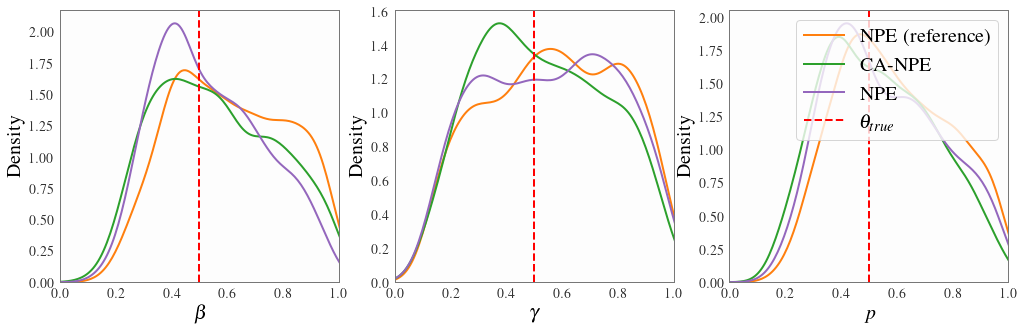

In [17]:
seed = 1
plt.figure(figsize=[17,5])
plt.subplot(1, 3, 1)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,0], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[0], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')

plt.xlabel("$\\beta$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
# plt.title(f"MMD:{mmd[seed]:.2f}")

plt.subplot(1, 3, 2)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,1], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,1], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,1], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[1], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlabel("$\\gamma$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.subplot(1, 3, 3)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,2], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,2], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,2], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[2], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.legend(fontsize=20, loc=1)
plt.xlabel("$p$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.show()

# Cost plot

In [61]:
N = 100

beta = torch.linspace(0.1, 1, N)
beta_fixed = 0.5


gamma_fixed = 0.5
gamma = torch.linspace(0.1, 1, N)

p = torch.linspace(0.1, 1, N)
p_fixed = 0.5

beta_combined = beta_fixed * torch.ones_like(beta)
gamma_combined = gamma_fixed * torch.ones_like(gamma)
p_combined = p_fixed * torch.ones_like(p)

combination_beta = torch.stack((beta, gamma_combined, p_combined), dim=1)
combination_gamma = torch.stack((beta_combined, gamma, p_combined), dim=1)
combination_p = torch.stack((beta_combined, gamma_combined, p), dim=1)

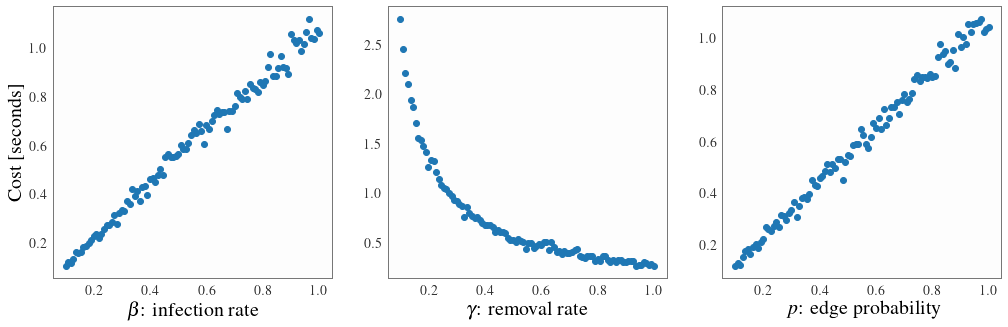

In [77]:
plt.figure(figsize=[17,5])
# plt.suptitle("     Bernoulli SIR", fontsize=20)

plt.subplot(1, 3, 1)
plt.scatter(beta, times_vs_beta/20)

plt.xlabel("$\\beta$: infection rate", fontsize=20)
plt.ylabel("Cost [seconds]", fontsize=20)
# plt.grid()

plt.subplot(1, 3, 2)
plt.scatter(gamma, times_vs_gamma/20)

plt.xlabel("$\\gamma$: removal rate", fontsize=20)

# plt.grid()

plt.subplot(1, 3, 3)
plt.scatter(p, times_vs_p/20)

plt.xlabel("$p$: edge probability", fontsize=20)

# plt.grid()

plt.savefig("plot_cost_bern_sir.pdf")
plt.show()